## 2. graphs associated with predicted output
* (actually, firstly going to merge the two csv into 1)
* these plots are basic

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from glob import glob
import seaborn as sns
import xesmf as xe
import pandas as pd
#import def_homebrew as hb ## homemade functions xox
from scipy.special import gamma
import netCDF4 as nc
from datetime import datetime, timedelta

import h5py ####
from PIL import Image
#from IPython.display import display #
#import cv2 # not working
import os
from scipy.ndimage import convolve, label
from skimage.measure import regionprops, find_contours
from scipy.spatial import ConvexHull, distance_matrix
from skimage.morphology import remove_small_holes ## remove holes <3
from scipy.ndimage import binary_fill_holes
from scipy.stats import gamma # gamma distribution
from skimage import measure
from cv2 import cvtColor, COLOR_BGR2GRAY, threshold, THRESH_BINARY, THRESH_OTSU

#### i am a bit silly, the names in habit stats do not match the ones written in habit prediction (missing info about channel etc) so need to add it to the habit prediction name column to work

In [40]:
#save_loc = '/gws/nopw/j04/dcmex/users/ezriab/2dprocessed/flight_220730153000/'
save_loc = '/gws/nopw/j04/dcmex/users/ezriab/processed_images/2ds/ch_0/220730153000/'
habit_csv = 'habit_predictions.csv'
#stats_csv = 'particle_stats.csv'
stats_csv = 'flight_220730153000.csv'
save_name = '220730153000_stats_habits.csv'

habits = pd.read_csv(save_loc+habit_csv)
stats = pd.read_csv(save_loc+stats_csv)

addition_name = '_ch_0'
habits['Name'] = habits['Name'] + '_ch_0'
# also going to rename habits name column, as is v annoying
habits.rename(columns={'Name':'name'}, inplace=True)


In [44]:
## merge the two csv files into one dataframe - based on name
# as i had to delete some images, habits is missing some values

if stats['name'].count() > habits['name'].count():
    merged_df = stats.merge(habits, on='name', how='left')

    # Sort the merged DataFrame by the 'Name' column
    merged_df = merged_df.sort_values(by='name').reset_index(drop=True)
    
'''
# Convert 'name' column to string in stats if it's not already
stats['name'] = stats['name'].astype(str)
# Convert 'Name' column to string in habits if it's not already
habits['Name'] = habits['Name'].astype(str)

# Merge the dataframes on the corresponding name columns
merged_df = pd.merge(stats, habits, left_on='name', right_on='Name', how='left')

# Drop the duplicate 'Name' column from habits if it's not needed
merged_df.drop(columns=['Name'], inplace=True)
'''
# Save the merged dataframe to a CSV file if needed
merged_df.to_csv(save_loc+save_name, index=False)


In [43]:
merged_df

,name,date,slice_s_idx,slice_e_idx,start_time,end_time,d_max,d_min,orientation,centroid,...,Category,CA,Co,CC,CBC,CG,HPC,Dif,FA,WD
0,1000081_1_ch_0,220730,1000081,1000392,19:17:23.301000000,19:17:23.301000000,3258.403608,40.236194,-1.569667,"(2.304301075268817, 126.18494623655914)",...,Co,0.0,1.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0
1,1001384_1_ch_0,220730,1001384,1001959,19:17:28.901000000,19:17:28.901000000,5989.083399,51.670406,1.567242,"(2.4518360830228847, 220.50186269292178)",...,Co,0.0,1.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0
2,1002210_1_ch_0,220730,1002210,1002281,19:17:28.901000000,19:17:28.901000000,709.747294,217.266005,-1.436207,"(13.59194214876033, 37.025826446280995)",...,Co,0.0,1.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0
3,1002353_1_ch_0,220730,1002353,1003004,19:17:28.901000000,19:17:28.901000000,5666.177482,824.256843,-1.348257,"(62.72577991977143, 314.0045597529653)",...,CG,0.0,0.0,0.0,0.0,1.0,1.347993e-10,0.0,0.0,0.0
4,1003804_1_ch_0,220730,1003804,1003840,19:17:33.644000000,19:17:33.644000000,387.660928,54.675581,1.511037,"(3.730769230769231, 12.634615384615385)",...,Co,0.0,1.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5496,998901_1_ch_0,220730,998901,998960,19:16:26.642000000,19:16:42.647000000,539.116175,324.689569,-1.442213,"(16.020881670533644, 25.754833720030934)",...,CG,0.0,0.0,0.0,0.0,1.0,0.000000e+00,0.0,0.0,0.0
5497,998981_1_ch_0,220730,998981,999332,19:16:48.638000000,19:17:04.643000000,3149.313350,1249.300992,-1.435933,"(59.19762702288228, 162.4492110254651)",...,CBC,0.0,0.0,0.0,1.0,0.0,0.000000e+00,0.0,0.0,0.0
5498,999333_1_ch_0,220730,999333,999567,19:17:04.643000000,19:17:14.643000000,2232.943917,399.904769,1.456554,"(21.181970203709334, 132.20462146549104)",...,Co,0.0,1.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0
5499,999568_1_ch_0,220730,999568,999777,19:17:14.643000000,19:17:17.638000000,1953.041937,285.393768,1.551880,"(16.51492902594224, 102.96133137542829)",...,Co,0.0,1.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0


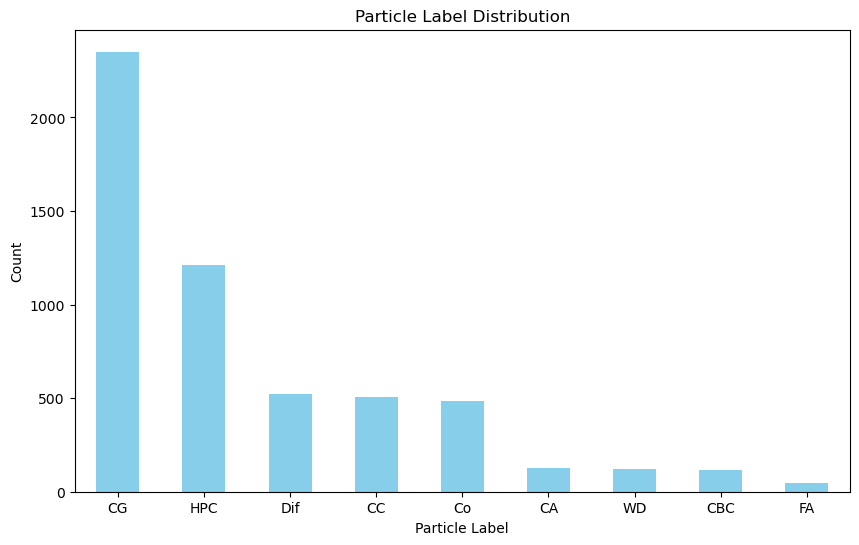

In [46]:
## very simple bar graph of all potential habits
habits = merged_df['Category'].value_counts() # Count the occurrences of each particle label

# Plot the bar graph
plt.figure(figsize=(10, 6))
habits.plot(kind='bar', color='skyblue')
plt.xlabel('Particle Label')
plt.ylabel('Count')
plt.title('Particle Label Distribution')
plt.xticks(rotation=0)
plt.show()

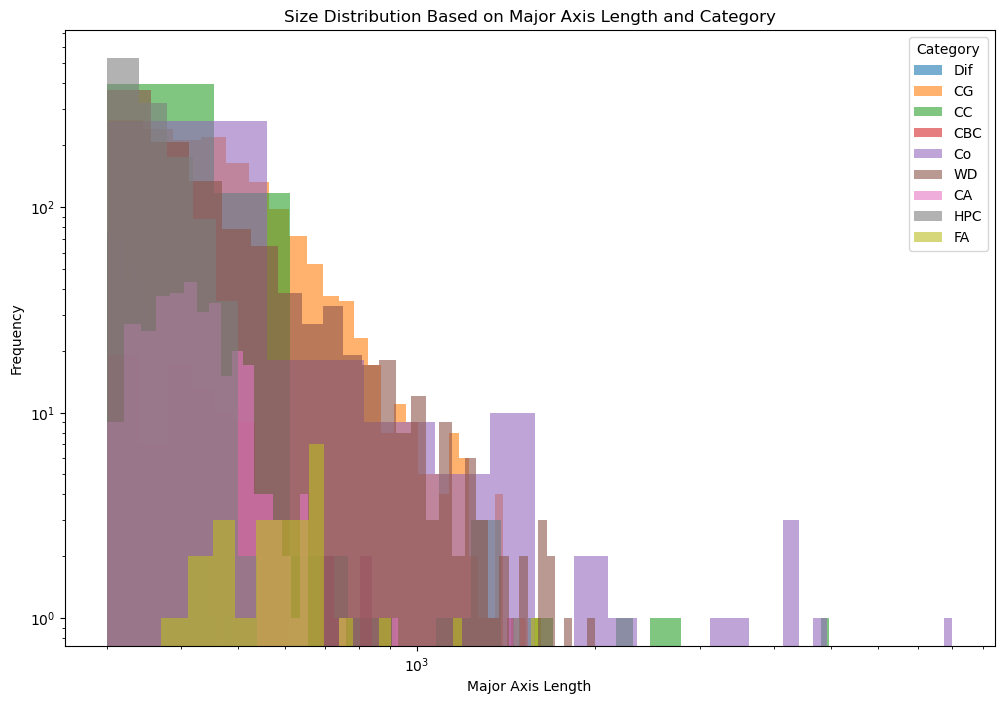

In [6]:
# Plot the size distribution based on major_axis_length and Category
plt.figure(figsize=(12, 8))

categories = merged_df['Category'].unique()
for category in categories:
    subset = merged_df[merged_df['Category'] == category]
    plt.hist(subset['major_axis_length'], bins=30, alpha=0.6, label=category)

plt.xlabel('Major Axis Length')
plt.ylabel('Frequency')
plt.yscale('log')
plt.xscale('log')
plt.title('Size Distribution Based on Major Axis Length and Category')
plt.legend(title='Category')
plt.show()


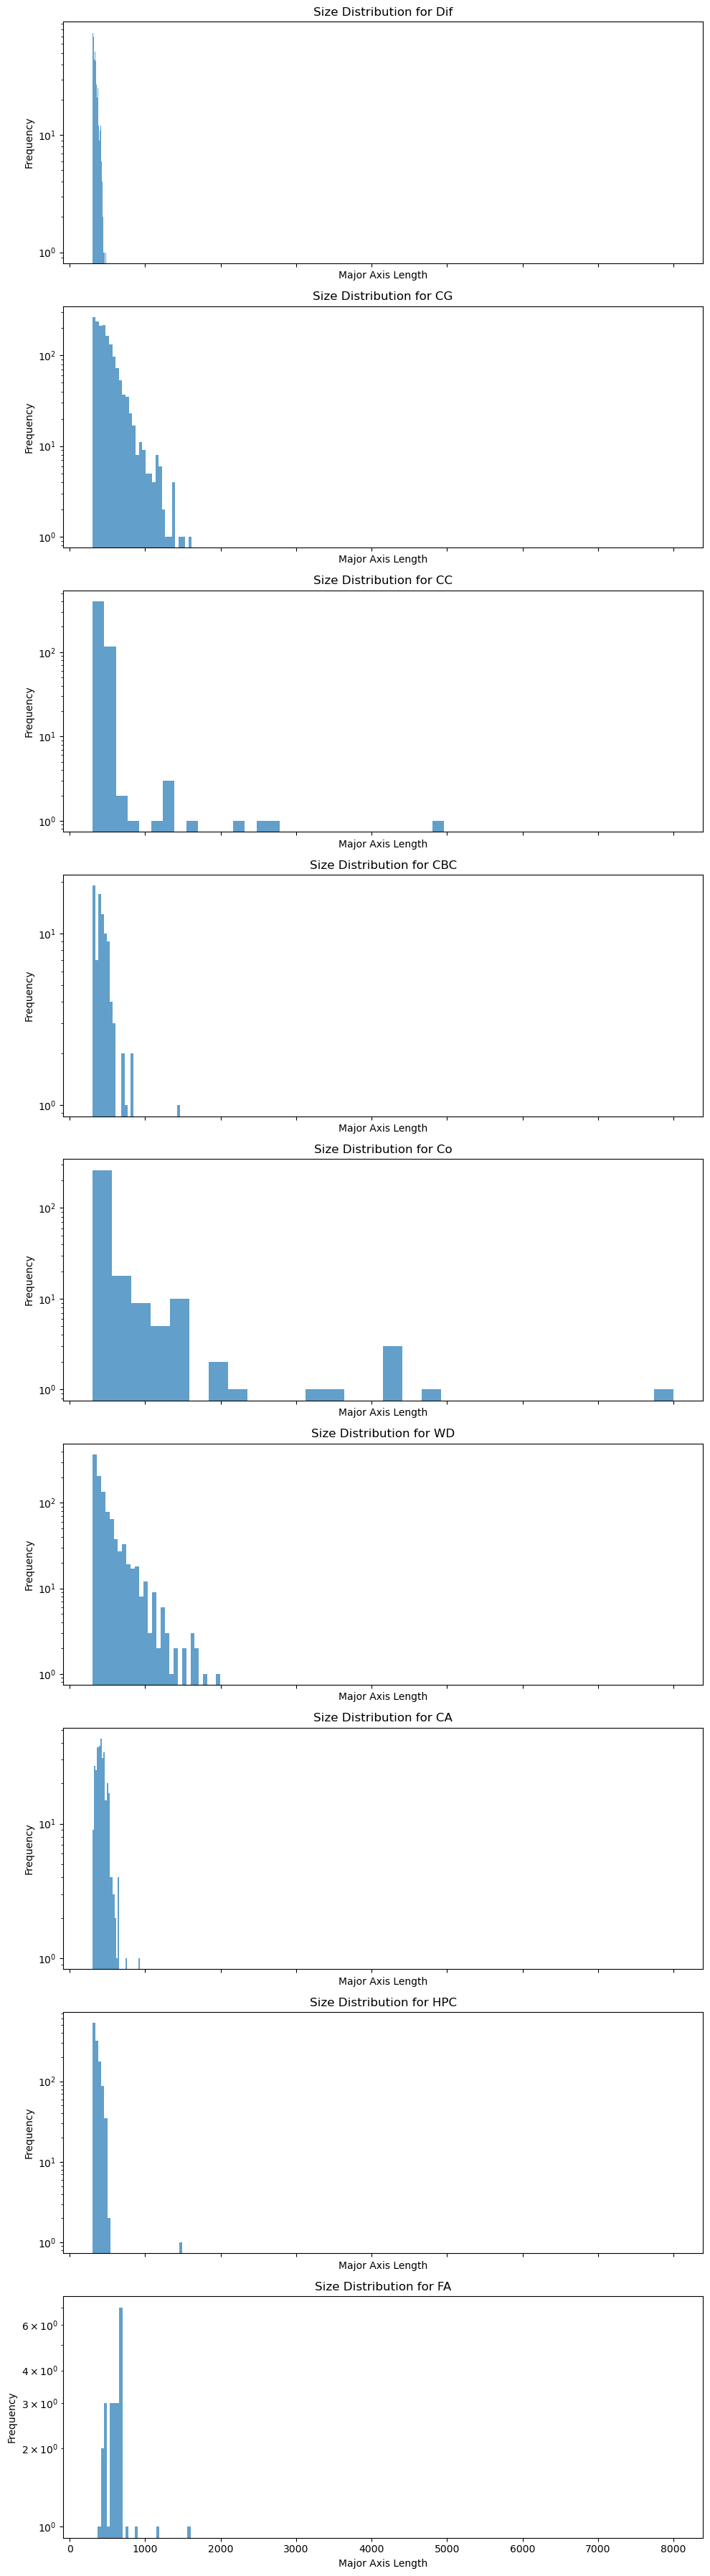

In [14]:
# Create subplots for each category
fig, axes = plt.subplots(len(categories), 1, figsize=(10, len(categories) * 4), sharex=True)

for ax, category in zip(axes, categories):
    subset = merged_df[merged_df['Category'] == category]
    ax.hist(subset['major_axis_length'], bins=30, alpha=0.7)
    ax.set_title(f'Size Distribution for {category}')
    ax.set_xlabel('Major Axis Length')
    ax.set_ylabel('Frequency')
    ax.set_yscale('log')
    

plt.tight_layout()
plt.show()

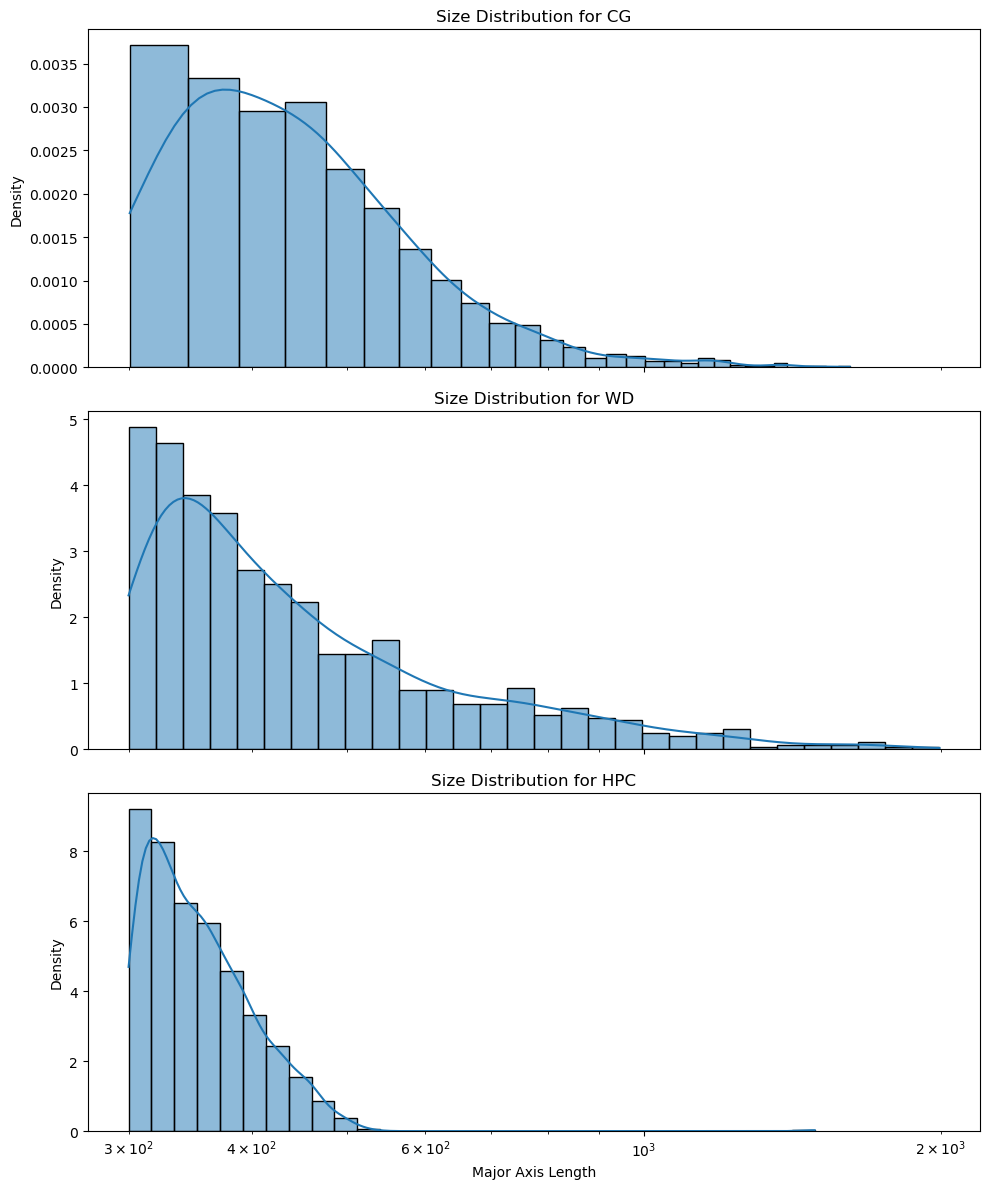

In [7]:
#graphs for only specific categories
categories = merged_df['Category'].unique()
categories_of_interest = ['CG','WD','HPC']

filtered_df = merged_df[merged_df['Category'].isin(categories_of_interest)]


# Create subplots for each category
fig, axes = plt.subplots(len(categories_of_interest), 1, figsize=(10, len(categories_of_interest) * 4), sharex=True)

for ax, category in zip(axes, categories_of_interest):
    subset = merged_df[merged_df['Category'] == category]
    sns.histplot(subset['major_axis_length'], bins=30, kde=True, ax=ax, stat="density")

    '''
    # Fit a normal distribution
    mu, std = norm.fit(subset['major_axis_length'])
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax.plot(x, p, 'k', linewidth=2)
    
    # Fit a gamma distribution
    params = gamma.fit(subset['major_axis_length'])
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = gamma.pdf(x, *params)
    ax.plot(x, p, 'k', linewidth=2)
    '''
    ax.set_title(f'Size Distribution for {category}')
    #ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel('Major Axis Length')
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

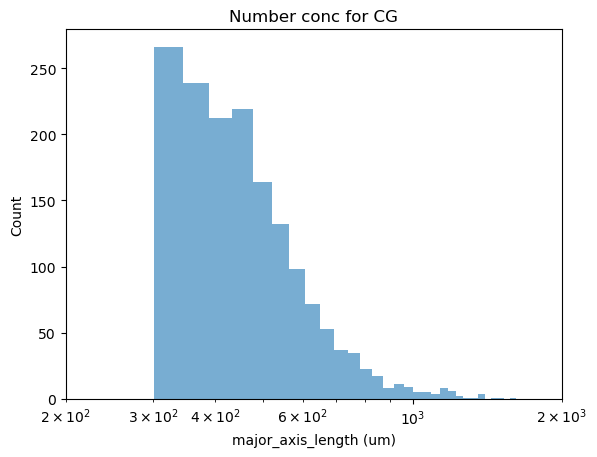

In [43]:
# one specif habit
# Specify the category of interest
category_of_interest = 'CG'
variable = 'major_axis_length'

# Filter the dataframe to include only the specified category
subset = merged_df[merged_df['Category'] == category_of_interest]
plt.xlim(200,2000)
plt.xscale('log')
#plt.yscale('log')
plt.hist(subset[variable], bins=30, alpha=0.6)

'''
# Plot the distribution for the specified category
plt.figure(figsize=(10, 6))
sns.histplot(subset[variable], bins=30, kde=False, stat="density")

# Fit a gamma distribution
params = gamma.fit(subset[variable])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = gamma.pdf(x, *params)
plt.plot(x, p, 'k', linewidth=2)
'''
plt.title(f'Number conc for {category_of_interest}')
plt.xlabel(variable+' (um)')
plt.ylabel('Count')



plt.show()